In [1]:
from pathlib import Path

import nibabel as nib
from nilearn.interfaces.bids import get_bids_files, parse_bids_filename
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import datasets
from nilearn.connectome import GroupSparseCovariance
from nilearn import plotting

from nilearn.connectome import GroupSparseCovarianceCV
from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

import matplotlib.pyplot as plt
import pandas as pd


import sys
sys.path.append("..")
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.data.memento import Memento
from bold_dementia.connectivity.matrices import plot_matrices


# TODO Complete test of rsn41
BIDSDIR = Path("/georges/memento/BIDS")
ATLAS = "msdl"

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


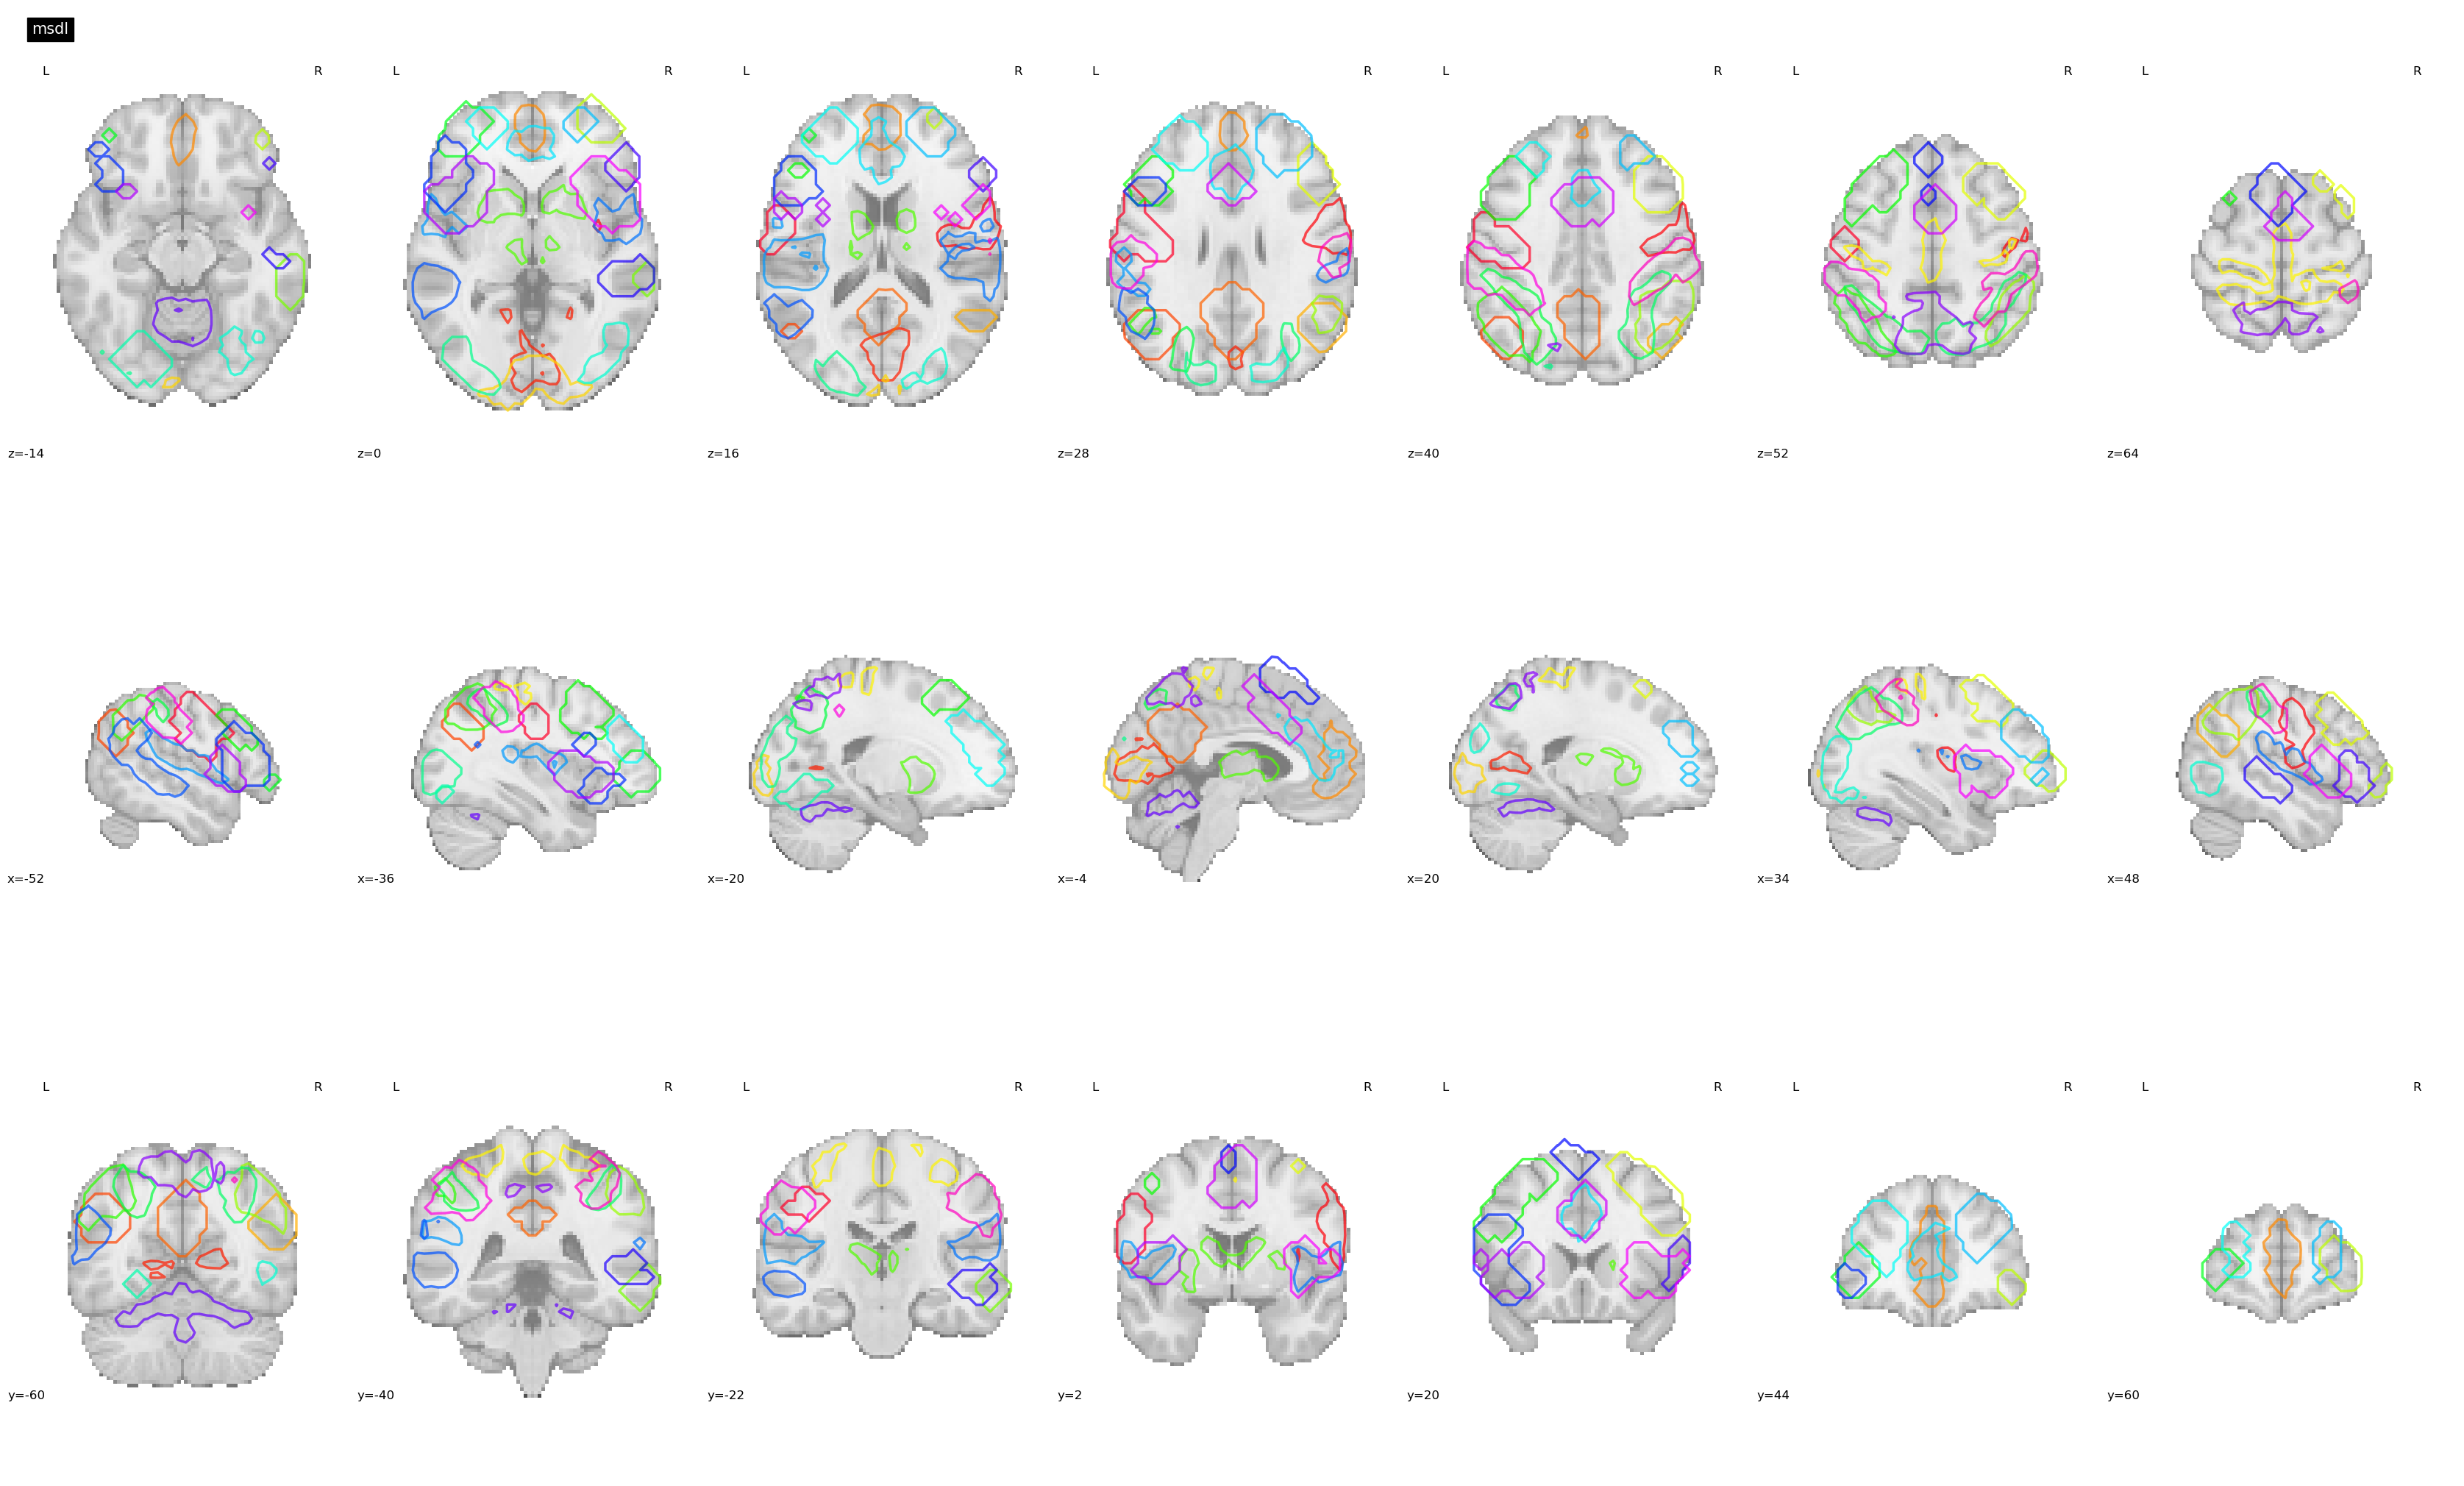

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS']


In [2]:
atlas = Atlas.from_name(ATLAS, soft=True)
atlas.plot(display_mode="mosaic")
plotting.show()
print(atlas.labels)

In [3]:
fmri_path = get_bids_files(
    BIDSDIR / "derivatives/fmriprep-23.2.0",
    "bold",
    modality_folder="func",
    file_type="nii.gz",
    filters=[
    #    #("space", "MNI152NLin2009cAsym")
        ("space", "MNI152NLin6Asym")
    ],
)

In [4]:
df = pd.DataFrame(map(parse_bids_filename, fmri_path))

ses_count = df.groupby("sub")["ses"].count()

complete_subs = ses_count[ses_count == 3].index.to_list()
complete_df = df[df["sub"].isin(complete_subs)]

In [4]:

phenotypes = Memento.load_phenotypes("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv", augmented=True)
phenotypes["sub"] = phenotypes["NUM_ID"].map(lambda x: x[4:])
phenotypes["is_demented"] = ~phenotypes.DEMENCE_DAT.isna()

In [6]:
rest_dataset = pd.merge(
    left=complete_df,
    right=phenotypes,
    how="left",
    on="sub"
)
if any(rest_dataset["CEN_ANOM"].isna()):
    import warnings
    warnings.warn("Not all subjects have a phenotype, some have been droppped")

    # For now we remove the subjects with no diagnosis
    rest_dataset = rest_dataset.dropna(axis=0, subset="CEN_ANOM")


/tmp/ipykernel_360746/1011048582.py:9: UserWarning: Not all subjects have a phenotype, some have been droppped
  warnings.warn("Not all subjects have a phenotype, some have been droppped")


In [7]:
masker = atlas.fit_masker()

confound_regression = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
time_series = []
for index, subrow in rest_dataset.sample(n=3).iterrows():
    # Preloading with nib is faster than passing a string path
    # to nilearn
    img = nib.load(subrow.file_path)
    confounds, sample_mask = load_confounds(
        subrow.file_path,
        **confound_regression
    )
    ts = masker.transform(img, confounds, sample_mask)
    time_series.append(ts)


In [8]:
pipe = make_pipeline(
    StandardScaler(),
    GraphicalLassoCV(n_jobs=8, max_iter=1000),
)
pipe.fit(time_series[1])
estimator = pipe.named_steps["graphicallassocv"]

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:132: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0005709603190227981
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:132: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.0003542972770250564
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/sklearn/covariance/_graph_lasso.py:132: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.00035489641313516345
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/homes_unix/jlegrand/miniconda

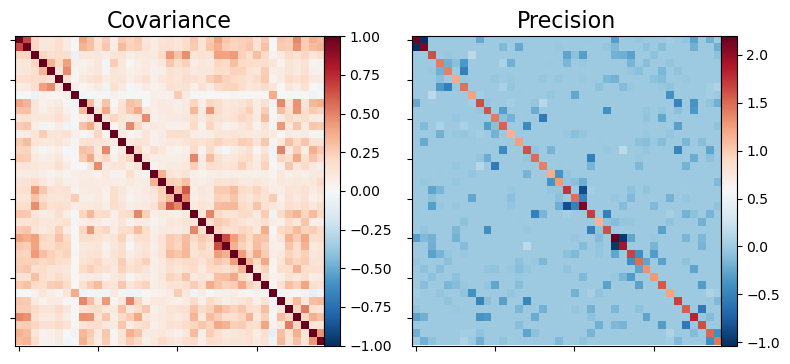

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plotting.plot_matrix(estimator.covariance_, axes=axes[0], vmax=1, vmin=-1, title="Covariance")
plotting.plot_matrix(estimator.precision_, axes=axes[1], title="Precision")
plt.show()

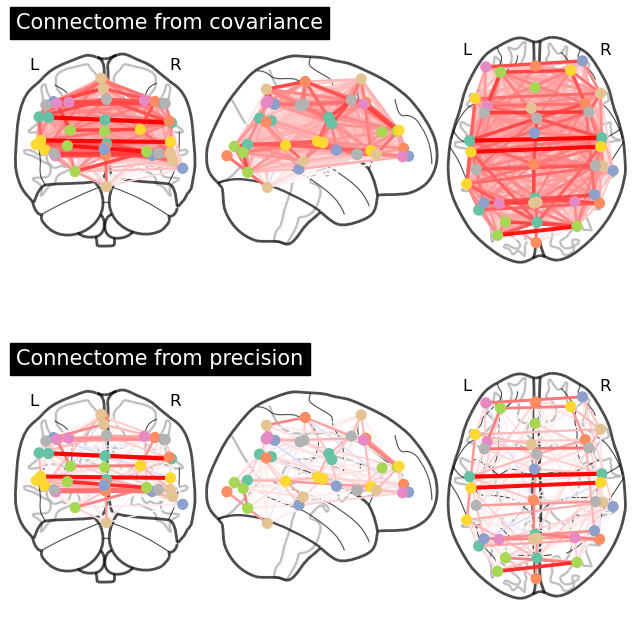

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))
plotting.plot_connectome(estimator.covariance_, node_coords=atlas.get_coords(), title="Connectome from covariance", axes=axes[0])
plotting.plot_connectome(-estimator.precision_, node_coords=atlas.get_coords(), title="Connectome from precision", axes=axes[1])
plotting.show()

In [11]:

gsc = GroupSparseCovariance()
sc = StandardScaler() # Could be refactored in a more elegant way but whatever
standardized_ts = [sc.fit_transform(ts) for ts in time_series]
gsc.fit(standardized_ts)

/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/nilearn/connectome/group_sparse_cov.py:494: UserWarning: Maximum number of iterations reached without getting to the requested tolerance level.
  warnings.warn(


GroupSparseCovariance()

TypeError: bad operand type for unary -: 'tuple'

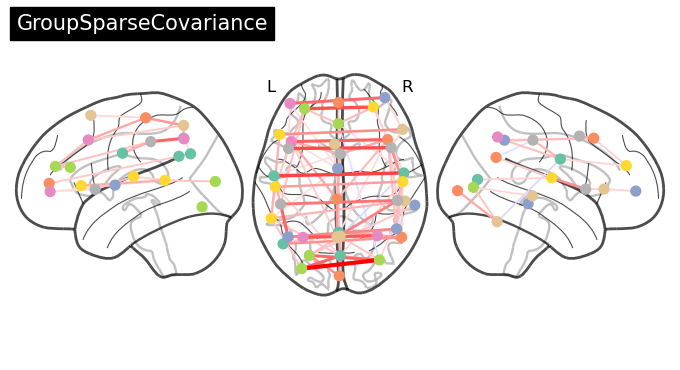

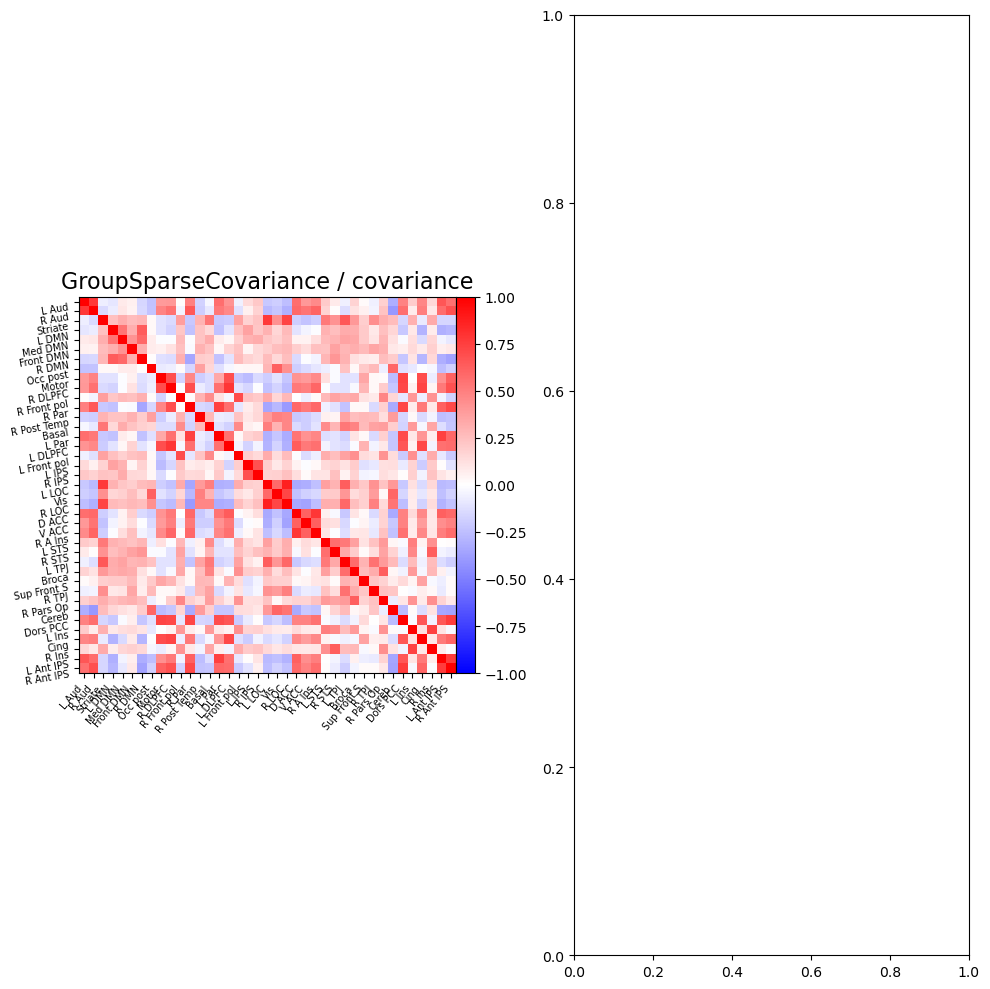

In [12]:
title = "GroupSparseCovariance"

plotting.plot_connectome(
    -gsc.precisions_.mean(axis=2),
    atlas.get_coords(),
    edge_threshold="90%",
    title=title,
    display_mode="lzr",
)
# Mean ou pas mean?
plot_matrices(gsc.covariances_.mean(axis=2), gsc.precisions_.mean(axis=2), title, atlas.labels)

plotting.show()